### Import necessary Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import glob
# import librosa
# import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
import torch.nn.functional as F
import torchaudio #only on linux
from tqdm import tqdm

DATA_DIR = './audio-data/speech'
TEXT_DATA = './data'

### check files in the directory to see if all are in the .wav format

We're gonna get the data file names from the directory and separate into wav and non wav files based on the file extensions

In [2]:
#get lists of the audio data and separate according to wav and non-wav filetypes
txt_df = pd.read_csv(f'{TEXT_DATA}/metadata-40229.csv')
txt_df['file_name'] = txt_df["sound"].str.split(".", n = 1, expand = True)[0]

files = os.listdir(DATA_DIR)
wav_files = sorted(glob.glob1(DATA_DIR,"*.wav"))
non_wav = np.setdiff1d(files,wav_files)

#get count and fracion of wav files
wav_count = len(wav_files)
wav_frac = wav_count/len(files)
print('%s of %s are .wav files'%(wav_count, len(files)))

14040 of 14041 are .wav files


In [3]:
# #check what other extensions are present
# ext = []
# for file in non_wav:
#     ext.append(file.split(".")[-1])
# file_types = list(set(ext))
# file_types

## Data loading and visualization

Let's load the data using torchaudio and place the data tensors and sampling rates into lists since there's more than one audio file

In [4]:
#helper function to load the data
def load_data(files, frac, data_type='train'):
    if data_type == 'train':
        aud_arr = []
        samp_arr = []
        for file in files[:int(frac*wav_count)]:
            data, sampling_rate = torchaudio.load(f'{DATA_DIR}/{file}')
            aud_arr.append(data)
            samp_arr.append(sampling_rate)

        file_names = [x.split('.')[0] for x in files[:int(frac*wav_count)]]
    else:
        aud_arr = []
        samp_arr = []
        for file in files[int(frac*wav_count):]:
            data, sampling_rate = torchaudio.load(f'{DATA_DIR}/{file}')
            aud_arr.append(data)
            samp_arr.append(sampling_rate)

        file_names = [x.split('.')[0] for x in files[int(frac*wav_count):]]
    return aud_arr, samp_arr, file_names

In [5]:
def get_text(txt_df, files):
    """
    Helper function to get text data corresponding to available audio files
    
    Args:
    txt_df - dataframe containing text data and metadata for the audio files
    files  - list of audio file names
    
    
    """
    df = txt_df[txt_df['file_name'].isin(files)]
    nan_files = df[df['text'].isnull()].file_name.values.tolist()
    
    return df.dropna(), nan_files
    

In [6]:
def del_missing(aud_arr, samp_arr, files, nan):
    for na in nan:
        idx = files.index(na)
        del(aud_arr[idx], samp_arr[idx], files[idx])

In [7]:
#get lists of items
train_arr, tr_samp, train_files = load_data(wav_files, 0.7, data_type='train')
test_arr, te_samp, test_files = load_data(wav_files, 0.7, data_type='valid')

#get text data
tr, tr_nan = get_text(txt_df, train_files)
te, te_nan = get_text(txt_df, test_files)

#remove items with missing texts
del_missing(train_arr, tr_samp, train_files, tr_nan)

Next, we're gonna play the first five audio files in jupyter lab and include their plots below

In [8]:
# ipd.Audio(f'{DATA_DIR}/{train_files[0]}')

ValueError: rate must be specified when data is a numpy array or list of audio samples.

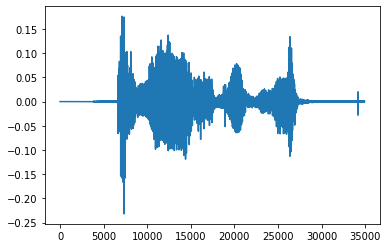

In [9]:
plt.figure()
plt.plot(train_arr[0].t().numpy())

In [10]:
# ipd.Audio(f'{DATA_DIR}/{train_files[1]}')

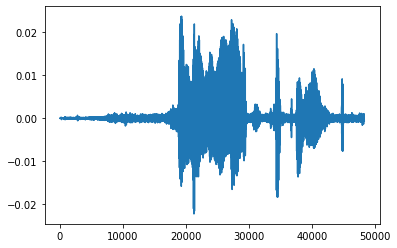

In [11]:
plt.figure()
plt.plot(train_arr[1].t().numpy())

In [12]:
# ipd.Audio(f'{DATA_DIR}/{train_files[2]}')

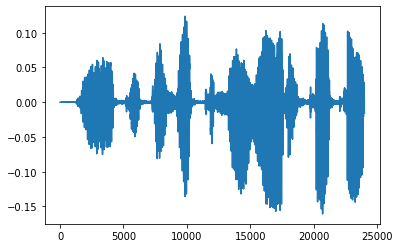

In [13]:
plt.figure()
plt.plot(train_arr[2].t().numpy())

In [14]:
# ipd.Audio(f'{DATA_DIR}/{train_files[3]}')

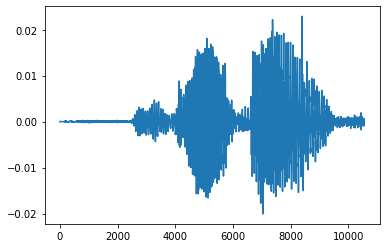

In [15]:
plt.figure()
plt.plot(train_arr[3].t().numpy())

In [16]:
# ipd.Audio(f'{DATA_DIR}/{train_files[4]}')

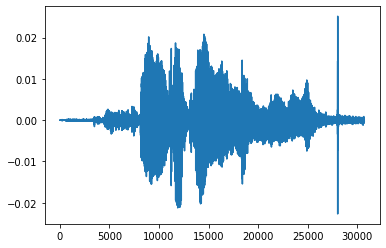

In [17]:
plt.figure()
plt.plot(train_arr[4].t().numpy())

Let's get the corresponding text files for each audio file

In [18]:
train_txt = txt_df[txt_df['file_name'].isin(train_files)].text.tolist()
valid_txt = txt_df[txt_df['file_name'].isin(test_files)].text.tolist()

## Data preprocessing and augmentation

Let's define a few functions for preparing the text and audio data before feeding it to the model

In [19]:
#module to transform characters in text to integers and and integers to text
class TextTransform:
    """Maps characters to integers and vice versa"""
    def __init__(self):
        #mapping of characters to their corresponding integer values(should we consider q?)
        char_map_str = """
        ' 0
        <SPACE> 1
        a 2
        b 3
        c 4
        d 5
        e 6
        f 7
        g 8
        h 9
        i 10
        j 11
        k 12
        l 13
        m 14
        n 15
        o 16
        p 17
        q 18
        r 19
        s 20
        t 21
        u 22
        v 23
        w 24
        x 25
        y 26
        z 27
        ! 28
        - 29
        . 30
        ? 31
        <APOS_1> 32
        <APOS_2> 33
        <QUOTES_1> 34
        <QUOTES_2> 35
        """
        self.char_map = {}#dict to place all char-int mappings
        self.index_map = {}#dict to place all int-char mappings
        
        #extract individual chars and ints from initial mapping and add to dicts
        for line in char_map_str.strip().split('\n'):
            ch, index = line.split()
            self.char_map[ch] = int(index)
            self.index_map[int(index)] = ch
        self.index_map[1] = ' '
    
    #helper function to convert text(chars) to integers
    def text_to_int(self, text):
        """
        Use a character map and convert text to an integer sequence.
        Notice that spaces in the text are also encoded with 1.
        
        args: text - text to be encoded
        """
        int_sequence = []
        for c in text:
            if c == ' ':
                ch = self.char_map['<SPACE>']
    
            elif c == '’':
                ch = self.char_map['<APOS_1>']
    
            elif c == '‘': 
                ch = self.char_map['<APOS_2>']
                
            elif c == '“':
                ch = self.char_map['<QUOTES_1>']
            
            elif c == '”':
                ch = self.char_map['<QUOTES_2>']
                
            else:
                ch = self.char_map[c]
            
            int_sequence.append(ch)
        return int_sequence
    
    #helper function to convert encoded text back
    def int_to_text(self, labels):
        """ 
        Use a character map and convert integer labels to a text sequence.
        It converts each integer into its corresponding char and joins the chars to form strings.
        Notice that the strings will be separated wherever the integer 1 appears.
        
        args: labels - integer values to be converted to texts(chars)
        """
        string = []
        for i in labels:
            string.append(self.index_map[i])
        return ''.join(string).replace('<SPACE>', ' ').replace('<APOS>', '’').replace('<QUOTES_1>', '“').replace('<QUOTES_2>', '”').replace('<APOS_2>', '‘')


We're going to increase the size of our data by augmenting the original data's mel spectograms by cutting out random blocks of consecutive time(time masking) and frequency (frequency masking) dimensions


In [20]:
#This transforms the audio data into mel spectograms and performs the data augmentation on the training data
train_audio_transforms = nn.Sequential(
    torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_mels=128),
    torchaudio.transforms.FrequencyMasking(freq_mask_param=15),
    torchaudio.transforms.TimeMasking(time_mask_param=35)
)

#Transform validation data into mel spectograms
valid_audio_transforms = torchaudio.transforms.MelSpectrogram()

#Load module for text encoding
text_transform = TextTransform()


In [21]:
#helper function for feature extraction
def data_processing(aud_arr, df, data_type="train", batch_size=5):
    """
    A function to transform and augment the audio data.
    
    args: 
    aud_arr - list of numpy arrays of the audio files
    df      - dataframe with the corresponding trascribed texts of the audio
    
    Returns:
    spectograms of the audio data, encoded text labels, length of audio recordings, length of encoded labels
    
    """    
    output = []
    tot_batch = df.shape[0]//batch_size
    
    #using the first five audio data and corresponding text data
    for batch_idx in tqdm(range(tot_batch)):
        spectrograms = []
        labels = []
        input_lengths = []
        label_lengths = []
        
        for (waveform, utterance) in zip(aud_arr[batch_size*batch_idx:batch_size*(batch_idx+1)], df.iloc[batch_size*batch_idx:batch_size*(batch_idx+1), 2]):
            #transform each audio file into a spectogram
            if data_type == 'train':
                spec = train_audio_transforms(waveform).squeeze(0).transpose(0, 1)
            else:
                spec = valid_audio_transforms(waveform).squeeze(0).transpose(0, 1)
            #collect spectograms of each audio file in a list
            spectrograms.append(spec)
            #encode the text data
            label = torch.Tensor(text_transform.text_to_int(utterance.lower()))
            #collect text data in a list
            labels.append(label)
            #collect input and label lengths in lists
            input_lengths.append(spec.shape[0]//2)
            label_lengths.append(len(label))
    
        #padding spectrogram ans labels so as to train with sequences of fixed lengths
        spectrograms = nn.utils.rnn.pad_sequence(spectrograms, batch_first=True).unsqueeze(1).transpose(2, 3)
        labels = nn.utils.rnn.pad_sequence(labels, batch_first=True)
        output.append([spectrograms, labels, input_lengths, label_lengths])
    return output

## Building the Model

The NN architecture employed is, like most of the code before, adapted from https://www.assemblyai.com/blog/end-to-end-speech-recognition-pytorch.
We're going to use a residual CNN and BiRNN(gated RNN) for the encoder which outputs a prob matrix that is then fed into the decoder for transcription of the data

### Pre-requisites

These are metrics to be used in the training and evaluation process

In [22]:
def avg_wer(wer_scores, combined_ref_len):
    return float(sum(wer_scores)) / float(combined_ref_len)


def _levenshtein_distance(ref, hyp):
    """Levenshtein distance is a string metric for measuring the difference
    between two sequences. Informally, the levenshtein disctance is defined as
    the minimum number of single-character edits (substitutions, insertions or
    deletions) required to change one word into the other. We can naturally
    extend the edits to word level when calculate levenshtein disctance for
    two sentences.
    """
    m = len(ref)
    n = len(hyp)

    # special case
    if ref == hyp:
        return 0
    if m == 0:
        return n
    if n == 0:
        return m

    if m < n:
        ref, hyp = hyp, ref
        m, n = n, m

    # use O(min(m, n)) space
    distance = np.zeros((2, n + 1), dtype=np.int32)

    # initialize distance matrix
    for j in range(0,n + 1):
        distance[0][j] = j

    # calculate levenshtein distance
    for i in range(1, m + 1):
        prev_row_idx = (i - 1) % 2
        cur_row_idx = i % 2
        distance[cur_row_idx][0] = i
        for j in range(1, n + 1):
            if ref[i - 1] == hyp[j - 1]:
                distance[cur_row_idx][j] = distance[prev_row_idx][j - 1]
            else:
                s_num = distance[prev_row_idx][j - 1] + 1
                i_num = distance[cur_row_idx][j - 1] + 1
                d_num = distance[prev_row_idx][j] + 1
                distance[cur_row_idx][j] = min(s_num, i_num, d_num)

    return distance[m % 2][n]


def word_errors(reference, hypothesis, ignore_case=False, delimiter=' '):
    """Compute the levenshtein distance between reference sequence and
    hypothesis sequence in word-level.
    :param reference: The reference sentence.
    :type reference: basestring
    :param hypothesis: The hypothesis sentence.
    :type hypothesis: basestring
    :param ignore_case: Whether case-sensitive or not.
    :type ignore_case: bool
    :param delimiter: Delimiter of input sentences.
    :type delimiter: char
    :return: Levenshtein distance and word number of reference sentence.
    :rtype: list
    """
    if ignore_case == True:
        reference = reference.lower()
        hypothesis = hypothesis.lower()

    ref_words = reference.split(delimiter)
    hyp_words = hypothesis.split(delimiter)

    edit_distance = _levenshtein_distance(ref_words, hyp_words)
    return float(edit_distance), len(ref_words)


def char_errors(reference, hypothesis, ignore_case=False, remove_space=False):
    """Compute the levenshtein distance between reference sequence and
    hypothesis sequence in char-level.
    :param reference: The reference sentence.
    :type reference: basestring
    :param hypothesis: The hypothesis sentence.
    :type hypothesis: basestring
    :param ignore_case: Whether case-sensitive or not.
    :type ignore_case: bool
    :param remove_space: Whether remove internal space characters
    :type remove_space: bool
    :return: Levenshtein distance and length of reference sentence.
    :rtype: list
    """
    if ignore_case == True:
        reference = reference.lower()
        hypothesis = hypothesis.lower()

    join_char = ' '
    if remove_space == True:
        join_char = ''

    reference = join_char.join(filter(None, reference.split(' ')))
    hypothesis = join_char.join(filter(None, hypothesis.split(' ')))

    edit_distance = _levenshtein_distance(reference, hypothesis)
    return float(edit_distance), len(reference)


def wer(reference, hypothesis, ignore_case=False, delimiter=' '):
    """Calculate word error rate (WER). WER compares reference text and
    hypothesis text in word-level. WER is defined as:
    .. math::
        WER = (Sw + Dw + Iw) / Nw
    where
    .. code-block:: text
        Sw is the number of words subsituted,
        Dw is the number of words deleted,
        Iw is the number of words inserted,
        Nw is the number of words in the reference
    We can use levenshtein distance to calculate WER. Please draw an attention
    that empty items will be removed when splitting sentences by delimiter.
    :param reference: The reference sentence.
    :type reference: basestring
    :param hypothesis: The hypothesis sentence.
    :type hypothesis: basestring
    :param ignore_case: Whether case-sensitive or not.
    :type ignore_case: bool
    :param delimiter: Delimiter of input sentences.
    :type delimiter: char
    :return: Word error rate.
    :rtype: float
    :raises ValueError: If word number of reference is zero.
    """
    edit_distance, ref_len = word_errors(reference, hypothesis, ignore_case,
                                         delimiter)

    if ref_len == 0:
        raise ValueError("Reference's word number should be greater than 0.")

    wer = float(edit_distance) / ref_len
    return wer


def cer(reference, hypothesis, ignore_case=False, remove_space=False):
    """Calculate charactor error rate (CER). CER compares reference text and
    hypothesis text in char-level. CER is defined as:
    .. math::
        CER = (Sc + Dc + Ic) / Nc
    where
    .. code-block:: text
        Sc is the number of characters substituted,
        Dc is the number of characters deleted,
        Ic is the number of characters inserted
        Nc is the number of characters in the reference
    We can use levenshtein distance to calculate CER. Chinese input should be
    encoded to unicode. Please draw an attention that the leading and tailing
    space characters will be truncated and multiple consecutive space
    characters in a sentence will be replaced by one space character.
    :param reference: The reference sentence.
    :type reference: basestring
    :param hypothesis: The hypothesis sentence.
    :type hypothesis: basestring
    :param ignore_case: Whether case-sensitive or not.
    :type ignore_case: bool
    :param remove_space: Whether remove internal space characters
    :type remove_space: bool
    :return: Character error rate.
    :rtype: float
    :raises ValueError: If the reference length is zero.
    """
    edit_distance, ref_len = char_errors(reference, hypothesis, ignore_case,
                                         remove_space)

    if ref_len == 0:
        raise ValueError("Length of reference should be greater than 0.")

    cer = float(edit_distance) / ref_len
    return cer


### The Encoder 

Let's define a few modules for use in building the encoder

In [23]:
class CNNLayerNorm(nn.Module):
    """Layer normalization built for cnns input"""
    def __init__(self, n_feats):
        super(CNNLayerNorm, self).__init__()
        self.layer_norm = nn.LayerNorm(n_feats)

    def forward(self, x):
        # x (batch, channel, feature, time)
        x = x.transpose(2, 3).contiguous() # (batch, channel, time, feature)
        x = self.layer_norm(x)
        return x.transpose(2, 3).contiguous() # (batch, channel, feature, time) 



In [24]:
class ResidualCNN(nn.Module):
    """
    Residual CNN inspired by https://arxiv.org/pdf/1603.05027.pdf except with layer norm instead of batch norm.
    Used to extract features from the spectrograms
        
    """
    def __init__(self, in_channels, out_channels, kernel, stride, dropout, n_feats):
        super(ResidualCNN, self).__init__()

        self.cnn1 = nn.Conv2d(in_channels, out_channels, kernel, stride, padding=kernel//2)
        self.cnn2 = nn.Conv2d(in_channels, out_channels, kernel, stride, padding=kernel//2)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.layer_norm1 = CNNLayerNorm(n_feats)
        self.layer_norm2 = CNNLayerNorm(n_feats)

    def forward(self, x):
        residual = x  # (batch, channel, feature, time)
        x = self.layer_norm1(x)
        x = F.gelu(x)
        x = self.dropout1(x)
        x = self.cnn1(x)
        x = self.layer_norm2(x)
        x = F.gelu(x)
        x = self.dropout2(x)
        x = self.cnn2(x)
        x += residual
        return x # (batch, channel, feature, time)



In [25]:
class BidirectionalGRU(nn.Module):
    """
    BiGRU network for the encoder to learn the pattern in the features extracted using the ResCNN
    """

    def __init__(self, rnn_dim, hidden_size, dropout, batch_first):
        super(BidirectionalGRU, self).__init__()

        self.BiGRU = nn.GRU(input_size=rnn_dim, hidden_size=hidden_size, num_layers=1, batch_first=batch_first, bidirectional=True)
        self.layer_norm = nn.LayerNorm(rnn_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.layer_norm(x)
        x = F.gelu(x)
        x, _ = self.BiGRU(x)
        x = self.dropout(x)
        return x


In [26]:
class SpeechRecognitionModel(nn.Module):
    '''
    Pipeline for the entire encoder architecture
    
    '''
    
    def __init__(self, n_cnn_layers, n_rnn_layers, rnn_dim, n_class, n_feats, stride=2, dropout=0.1):
        super(SpeechRecognitionModel, self).__init__()
        n_feats = n_feats//2
        self.cnn = nn.Conv2d(1, 32, 3, stride=stride, padding=3//2)  # cnn for extracting heirachal features

        # n residual cnn layers with filter size of 32
        self.rescnn_layers = nn.Sequential(*[
                                            ResidualCNN(32, 32, kernel=3, stride=1, dropout=dropout, n_feats=n_feats) 
                                            for _ in range(n_cnn_layers)
        ])
        self.fully_connected = nn.Linear(n_feats*32, rnn_dim)
        self.birnn_layers = nn.Sequential(*[
                                            BidirectionalGRU(rnn_dim=rnn_dim if i==0 else rnn_dim*2, hidden_size=rnn_dim, dropout=dropout, batch_first=i==0)
                                            for i in range(n_rnn_layers)
        ])
        self.classifier = nn.Sequential(
                                        nn.Linear(rnn_dim*2, rnn_dim),  # birnn returns rnn_dim*2
                                        nn.GELU(),
                                        nn.Dropout(dropout),
                                        nn.Linear(rnn_dim, n_class)
        )

    def forward(self, x):
        x = self.cnn(x)
        x = self.rescnn_layers(x)
        sizes = x.size()
        x = x.view(sizes[0], sizes[1] * sizes[2], sizes[3])  # (batch, feature, time)
        x = x.transpose(1, 2) # (batch, time, feature)
        x = self.fully_connected(x)
        x = self.birnn_layers(x)
        x = self.classifier(x)
        return x


## The Decoder

In [27]:
def GreedyDecoder(output, labels, label_lengths, blank_label=28, collapse_repeated=True):
    arg_maxes = torch.argmax(output, dim=2)
    decodes = []
    targets = []
    for i, args in enumerate(arg_maxes):
        decode = []
        targets.append(text_transform.int_to_text(labels[i][:label_lengths[i]].tolist()))
        for j, index in enumerate(args):
            if index != blank_label:
                if collapse_repeated and j != 0 and index == args[j -1]:
                    continue
                decode.append(index.item())
        decodes.append(text_transform.int_to_text(decode))
    return decodes, targets


## Training and evaluation

We're going to use a pipeline that runs the entire training process and evaluates on the validation data

In [28]:
class IterMeter(object):
    """keeps track of total iterations"""
    def __init__(self):
        self.val = 0

    def step(self):
        self.val += 1

    def get(self):
        return self.val


In [29]:
#helper function for training the network
def train(model, device, train_loader, criterion, optimizer, scheduler, epoch, iter_meter, tr):
    model.train()
    data_len = tr.shape[0]
    for batch_idx, _data in enumerate(train_loader):
        spectrograms, labels, input_lengths, label_lengths = _data 
        spectrograms, labels = spectrograms.to(device), labels.to(device)

        optimizer.zero_grad()

        output = model(spectrograms)  # (batch, time, n_class)
        output = F.log_softmax(output, dim=2)
        output = output.transpose(0, 1) # (time, batch, n_class)

        loss = criterion(output, labels, input_lengths, label_lengths)
        loss.backward()
        optimizer.step()
        scheduler.step()
        iter_meter.step()
        
        if batch_idx % 100 == 0 or batch_idx == data_len:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(spectrograms), data_len,
                100. * batch_idx / len(train_loader), loss.item()))


In [30]:
#helper function for evaluating the training process
def test(model, device, test_loader, criterion, epoch, iter_meter):
    print('\nevaluating...')
    model.eval()
    test_loss = 0
    test_cer, test_wer = [], []
    with torch.no_grad():
        for i, _data in enumerate(test_loader):
            spectrograms, labels, input_lengths, label_lengths = _data 
            spectrograms, labels = spectrograms.to(device), labels.to(device)

            output = model(spectrograms)  # (batch, time, n_class)
            output = F.log_softmax(output, dim=2)
            output = output.transpose(0, 1) # (time, batch, n_class)

            loss = criterion(output, labels, input_lengths, label_lengths)
            test_loss += loss.item() / len(test_loader)

            decoded_preds, decoded_targets = GreedyDecoder(output.transpose(0, 1), labels, label_lengths)
            for j in range(len(decoded_preds)):
                test_cer.append(cer(decoded_targets[j], decoded_preds[j]))
                test_wer.append(wer(decoded_targets[j], decoded_preds[j]))


    avg_cer = sum(test_cer)/len(test_cer)
    avg_wer = sum(test_wer)/len(test_wer)

    print('Test set: Average loss: {:.4f}, Average CER: {:4f} Average WER: {:.4f}\n'.format(test_loss, avg_cer, avg_wer))

In [31]:
#pipeline to train and evaluate the model
def main(train_arr, test_arr, tr, te, learning_rate=5e-4, batch_size=20, epochs=10):

    hparams = {
        "n_cnn_layers": 3,
        "n_rnn_layers": 5,
        "rnn_dim": 512,
        "n_class": 29,
        "n_feats": 128,
        "stride":2,
        "dropout": 0.1,
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "epochs": epochs
    }

    
    use_cuda = torch.cuda.is_available()
    torch.manual_seed(7)
    device = torch.device("cuda" if use_cuda else "cpu")

    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
    train_loader = data_processing(train_arr, tr, data_type='train')
    test_loader = data_processing(test_arr, te, data_type='valid')

    model = SpeechRecognitionModel(
        hparams['n_cnn_layers'], hparams['n_rnn_layers'], hparams['rnn_dim'],
        hparams['n_class'], hparams['n_feats'], hparams['stride'], hparams['dropout']
        ).to(device)

    print(model)
    print('Num Model Parameters', sum([param.nelement() for param in model.parameters()]))

    optimizer = optim.AdamW(model.parameters(), hparams['learning_rate'])
    criterion = nn.CTCLoss(blank=28).to(device)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=hparams['learning_rate'], 
                                            steps_per_epoch=int(len(train_loader)),
                                            epochs=hparams['epochs'],
                                            anneal_strategy='linear')
    
    iter_meter = IterMeter()
    for epoch in range(1, epochs + 1):
        train(model, device, train_loader, criterion, optimizer, scheduler, epoch, iter_meter, tr)
        test(model, device, test_loader, criterion, epoch, iter_meter)
    return model


In [32]:
model = main(train_arr, test_arr, tr, te)

100%|██████████| 839/839 [00:13<00:00, 61.86it/s]


SpeechRecognitionModel(
  (cnn): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (rescnn_layers): Sequential(
    (0): ResidualCNN(
      (cnn1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (cnn2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
      (layer_norm1): CNNLayerNorm(
        (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      )
      (layer_norm2): CNNLayerNorm(
        (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      )
    )
    (1): ResidualCNN(
      (cnn1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (cnn2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
      (layer_norm1): CNNLayerNorm(
        (layer_norm): LayerNorm((64,),

KeyboardInterrupt: 